## Машинное обучение 
### Факультет математики НИУ ВШЭ, 2019-20 учебный год

_Илья Щуров, Соня Дымченко, Руслан Хайдуров, Александр Каган, Павел Балтабаев_

[Страница курса](http://wiki.cs.hse.ru/Машинное_обучение_на_матфаке_2020)


## Домашнее задание 3. Метод k ближайших соседей

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(90300) # 09.03.2000 b/day
plt.ioff()

## О библиотеках
В задачах 1 и 2 вам предстоит написать функции, аналоги которых есть в библиотеке *scikit-learn* (`sklearn`). Реализовывать различные методы машинного обучения «с нуля» очень полезно: способность реализовать какой-то метод самому — это главный критерий того, что вы понимаете, как он работает. В то же время, разбираться в существующих библиотеках тоже полезно — именно с ними вам придётся столкнуться в любой практической работе. Поэтому мы рекомендуем решить эти задачи двумя способами: вручную и с помощью `sklearn`. За оба положены баллы (хотя за `sklearn` поменьше, потому что это проще).

## Задание 1 (4+1 баллов)

Вам предстоит реализовать две версии метода $k$ ближайших соседей (kNN) — обычный (который обсуждался на семинаре) и со взвешиванием.

В качестве метрики мы будем использовать $d_p(\cdot,\ \cdot)$ — [расстояние Минковского](https://en.wikipedia.org/wiki/Minkowski_distance) порядка $p$.



Пусть нам нужно вычислить значение $y$ для некоторого $x_{new}$, наши данные заданы как $\{x_i, y_i\}_{i=1}^l$. Обычный метод $k$ ближайших соседей находит такие $i_1, \ldots, i_k$, что $\{x_{i_m}\}_{m=1}^k$ являются $k$ ближайшими соседями для точки $x_{new}$ (по выбранной метрике $d_p(\cdot,\ \cdot)$), и полагает, что значение нового объекта:

$$\widehat{y} = \underset{c \in C}{\mathrm{argmax}}\ \sum_{m=1}^k[y_{i_m} = c],$$
где $C$ — множество классов, а $[y_{i_m}=c]$ — выражение, равное 1, если $y_{i_m}=c$, и 0 в противном случае. То есть $\widehat y$ — мода классов $k$ ближайших соседей. Модифицированный метод $k$ ближайших соседей, который вам предстоит реализовать, использует другую оценку:

$$\widehat y = \underset{c \in C}{\mathrm{argmax}} \sum_{i=1}^l w_{i}[y_i=c],$$
где вес $w_i$ вычисляется следующим образом:
$$w_{i}=\frac{1}{d_p(x_{new}, x_{i})}.$$

Таким образом, модифицированный метод присваивает $i$-му объекту вес $w_{i}$, уменьшающийся с увеличением расстояния до $x_{new}$, вместо того чтобы присваивать $k$ ближайшим соседям вес $1$, а остальным $0$.

---

Ниже предоставлен шаблон функции для реализации метода, который возвращает предсказания для тестовой выборки, используя взвешенный или обычный kNN (с возможностью выбора порядка $p$ метрики расстояния). Код для обычного kNN можно взять из семинара; если вы не были на семинаре — придётся написать самостоятельно.

---

За решение задачи вручную (только с использованием `numpy` и `scipy`) можно получить **до четырёх баллов**. Полный балл за эту часть ставится в том случае, если решение не использует циклы. За решение с циклами можно получить не больше **двух баллов** из четырёх.

За решение задачи с помощью `sklearn` можно получить **один балл**.

**Подсказка.** Вам придётся вычислить расстояние Минковского между $x_{new}$ и каждой из точек $x_i$, $i=1,\ldots, l$. Существует библиотечная функция, которая позволяет это сделать быстро и без циклов. Вам нужно найти её и использовать.

In [3]:
from scipy.spatial import distance as dst

def knn_classifier(x_train, y_train, x_test, k=1, distance='euclid', 
                   weight=True):
    """
    x_train is np.array with shape (l, d) (matrix with l rows, d columns)
    y_train is np.array with shape (l, ) (1-dimensional array with l elements)
    x_test is np.array with shape (n, d) (matrix with n rows, d columns)
    k is int (if weight is True, then the argument is ignored, else - number of neighbours)
    distance is int (order p of Minkowski distance) or str: 'euclidian', 'cityblock' (you can implement more options)
    weight is boolean, whether to use the weighted method or not

    return y_test, np.array with shape (n, ) (1-dimensional array with n elements)
    """
    ### SOLUTION BEGIN
    
    p = 2 if distance == 'euclid' else int(distance)
    k = min(k, len(x_train) - 1)
    
    def predict(x_predict):
        # dsts = dst.minkowski(x_train, x_predict)
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.minkowski.html
        dsts = np.power(np.sum(np.power(np.abs(x_train - x_predict), p), axis=1), 1 / p)
        # Как показал опыт задачи 3.1 пункт 2 (где надо строить график), использование scipy в данном случае оказывается тупо дольше поэтому используем сделанную руками numpy
        
        knn_indexes = np.argpartition(dsts, k) # Индексы к-близких соседей
        knn_dsts = dsts[knn_indexes][:k] # Расстояния до соседей
        knn_classes = y_train[knn_indexes][:k] # Классы соседей
        unique_classes = np.unique(knn_classes) # Уникальные классы
        count_classes = len(unique_classes) #  Сколько всего уникальных классов
        class_partition = (unique_classes.reshape(1, -1).T == np.tile(knn_classes, (count_classes, 1)))
        # Для каждого класса смотрим оценку нашего knn_classes
        # Условно, было count_classes (пусть 3), 
        # Пусть наша а лежит в первом классе, тогда зануляем соседей всех кроме тех, что в первом классе и считаем "правдоподобие"
        # А дальше находим максимальный (что лучше всего подходит)
        
        if weight: #использовать взвешенный метод
            if (0 in knn_dsts):
                return knn_classes[(knn_dsts == 0)][0]
            summ = np.sum(
                        class_partition * 1 / np.tile(knn_dsts, (count_classes, 1)),
                                axis=1)
       
        else: # не использовать взвешенный
            summ = np.sum(class_partition * 1, axis=1)
            
        return unique_classes[np.argmax(summ)]
        
    return np.apply_along_axis(predict, 1, x_test)
    
    ### SOLUTION END

## Задание 2 (2 + 0.5 баллов)

На семинаре было рассказано про разные виды кросс-валидации. В этом задании вам предстоит реализовать собственноручно k-fold cross validation со стратификацией по параметру $y$ (целевой категориальной переменной).

Ниже предоставлен шаблон функции, которая делит данные на $K$ частей («фолдов»), каждая из которых имеет то же (или максимально близкое) распределение классов (то есть значений переменной $y$), что и целый датасет. Она должна вернуть $K$-элементный список, каждый элемент которого является четырёхэлементным кортежем: `(x_train, y_train, x_test, y_test)`, где `x_test, y_test` соответствует содержимому одного из фолдов, а `x_train, y_train` — всему остальному датасету. Если вы знаете, что такое генераторы, вместо того, чтобы возвращать $K$-элементный список, можете сделать соответствующий генератор.

Ниже есть код, который поможет вам себя проверить.

---

За решение задачи вручную ставится **2 балла** максимум. В задаче можно использовать циклы, однако следует помнить, что циклы в питоне — медленные, и при любой возможности следует использовать векторизованные функции `numpy`. За неоптимальное использование циклов оценка может быть снижена.

За решение задачи с помощью `sklearn` ставится **0.5 балла**.

In [4]:
def strat_kfold_gen(x, y, k):
    '''
    x is np.array with shape (l, d) (matrix with l rows, d columns)
    y is np.array with shape (l, ) (1-dimensional array with l elements)
    k is int, number of folds to split data

    returns x_train, y_train, x_test, y_test
    '''
    ### SOLUTION BEGIN
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    
    y = y[indexes]
    x = x[indexes]
    
    sorted_indexes = np.argsort(y)

    result = []
    for i in range(k):
        f = sorted_indexes[i::k]
        result.append((
            np.delete(x, f, axis=0), 
            np.delete(y, f), 
            x[f], 
            y[f] ))
    
    return result

    ### SOLUTION END

In [5]:
# CHECK YOURSELF

x = np.random.normal(size=(171, 3))
y = np.hstack([np.ones(101), np.ones(50) * 2, np.ones(20) * 3])
np.random.shuffle(y)
K = 5

s = '\nClass distribution train/test:'
t = '1 - {:.3f}\t2 - {:.3f}\t3 - {:.3f}'
print(f'ALL, length={len(y)}', 
      s, '\n\tALL:  ', t.format(*np.unique(y, return_counts=True)[1] / len(y)))
print('-'*70)
for i, (_, y_tr, _, y_t) in enumerate(strat_kfold_gen(x, y, K)):
    print(f'FOLD #{i+1}, length={len(y_tr)}/{len(y_t)}', 
          s, '\n\tTRAIN: ', t.format(*np.unique(y_tr, return_counts=True)[1] / len(y_tr)), 
             '\n\tTEST:  ', t.format(*np.unique(y_t, return_counts=True)[1] / len(y_t)))

ALL, length=171 
Class distribution train/test: 
	ALL:   1 - 0.591	2 - 0.292	3 - 0.117
----------------------------------------------------------------------
FOLD #1, length=136/35 
Class distribution train/test: 
	TRAIN:  1 - 0.588	2 - 0.294	3 - 0.118 
	TEST:   1 - 0.600	2 - 0.286	3 - 0.114
FOLD #2, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118
FOLD #3, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118
FOLD #4, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118
FOLD #5, length=137/34 
Class distribution train/test: 
	TRAIN:  1 - 0.591	2 - 0.292	3 - 0.117 
	TEST:   1 - 0.588	2 - 0.294	3 - 0.118


## Задание 3.1 (3 балла)

Теперь наконец применим наши две функции и посмотрим подробнее на результаты. Рассмотрим датасет [Thyroid Gland](https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.names), состоящий из результатов различных  анализов, связанных со щитовидной железой пациентов. Целевой переменной является состояние щитовидной железы: нормальное, гипотиреоз или гипертиреоз.

**1. (0.5 балла)** Скачайте датасет (https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv) и ответьте на следующие вопросы. Сколько у датасета строк и столбцов? Целевая переменная записана последним столбцом. Какое у неё распределение? (Постройте подходящую картинку.)

**Замечание.** Функция `pd.read_csv` по умолчанию считает, что названия столбцов указаны в первой строке файла, но в файле по ссылке названия столбцов не указаны. Прочитайте в документации, как сделать так, чтобы `pd.read_csv` не воспринимала первую строчку файла как названия столбцов.

data rows: 215 
data columns: 6


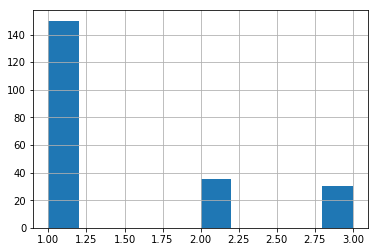

,0,1,2,3,4,5
0,107,10.1,2.2,0.9,2.7,1
1,113,9.9,3.1,2.0,5.9,1
2,127,12.9,2.4,1.4,0.6,1
3,109,5.3,1.6,1.4,1.5,1
4,105,7.3,1.5,1.5,-0.1,1


In [6]:
import io
import requests

URL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/new-thyroid.csv'

data = pd.read_csv(
    io.StringIO(requests.get(URL).content.decode('utf-8')), 
    header=None)
print('data rows: {} \ndata columns: {}'.format(*data.shape))
data[5].hist()
plt.show()

data.head()

**2. (2 балла)** Примените ваш kNN-алгоритм для предсказания значения целевой переменной, используя кросс-валидацию на 3 фолдах. (Вам нужно изготовить из датафрейма массивы numpy `x` и `y`, которые можно скормить функциям, написанным в задачах 1 и 2. Чтобы получить массив из датафрейма можно использовать свойство `.values`.) Перебирая значения параметра $k$ — количества ближайших соседей — от 0 до 20 нарисуйте два графика зависимости качества предсказания (будем использовать accuracy) от $k$ — один для обучающей и один для тестовой выборок. Можно рисовать отдельную линию на графике для каждого фолда, либо рисовать их среднее±разброс.

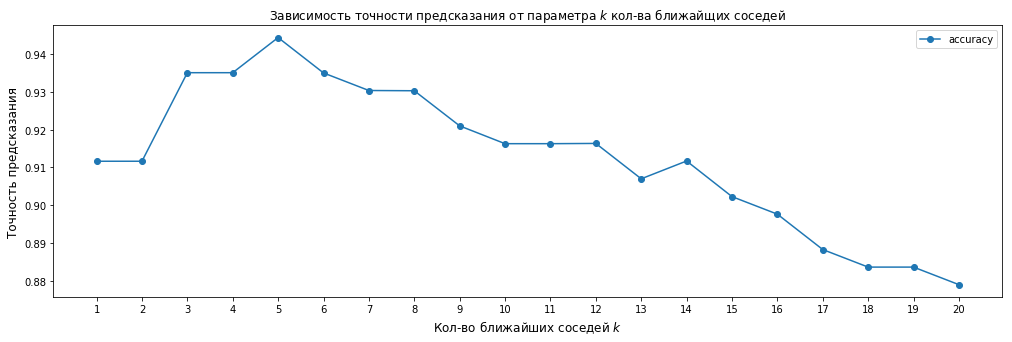

Best k= 5
Best accuracy= 0.9442488262910799


In [7]:
from sklearn import metrics
np.random.seed(90300)

Range = range(1, 21)

x = data.iloc[:, :5].values # вибираем все строки и их значения 0-4
y = data.iloc[:, 5].values # выбираем все строки и значение в 5

folds = strat_kfold_gen(x, y, 3)
Kneibrs = []

for k in Range:
    accuracy = []
    for x_train, y_train, x_test, y_test in folds:
        accuracy.append(metrics.accuracy_score(knn_classifier(x_train, y_train, x_test, k=k), y_test))
    
    Kneibrs.append(np.mean(accuracy))

plt.figure(figsize=(17, 5))
plt.xticks(Range)
plt.plot(Range, Kneibrs, label='accuracy', marker='o')
plt.title('Зависимость точности предсказания от параметра $k$ кол-ва ближайщих соседей')
plt.xlabel('Кол-во ближайших соседей $k$', fontsize=12)
plt.ylabel('Точность предсказания', fontsize=12)
plt.legend(loc='best')
plt.show()

k_best = np.argmax(Kneibrs) + 1

print('Best k= {}\nBest accuracy= {}'.format(k_best, Kneibrs[k_best-1]))

Как зависит качество от значения $k$ для каждой выборки? Как выбрать оптимальное значение? 

**Ваш ответ:** 

Как видно из графика наибольшая точность достигается при $k \sim 5$, до этого момента точность растет, а после -- падает (оверфитинг?).
Для выбора оптимального значения необходимо брать максимум по точности.
Очевидно, что на обучающей выборке при любом значении $k$ точность всегда максимальна, т.е. равна $1$.

**3. (0.5 балла)** Попробуйте улучшить качество модели, отмасштабировав данные таким образом, чтобы разброс значений всех переменных был примерно одинаковым (способ скейлинга на ваш выбор, см. модуль [sklearn-preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)). 

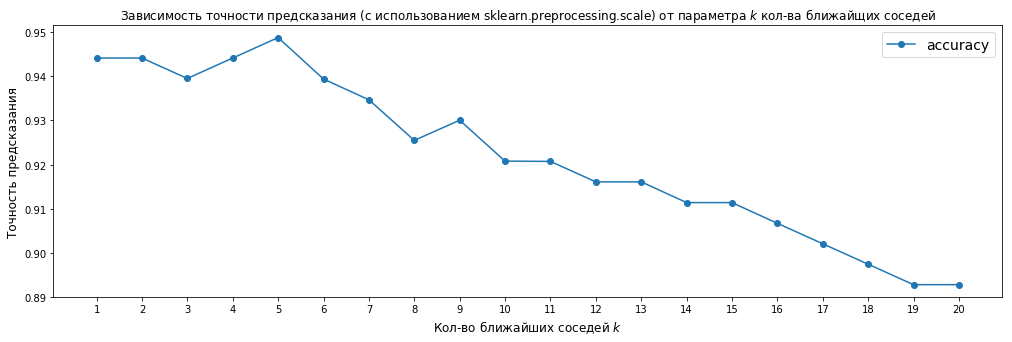

Best k= 5
Best accuracy= 0.9487480438184663


In [8]:
# from sklearn import metrics
# np.random.seed(90300)

# Range = range(1, 21)

# x = data.iloc[:, :5].values
# y = data.iloc[:, 5].values

from sklearn.preprocessing import scale

folds = strat_kfold_gen(scale(x), y, 3)
Kneibrs = []

for k in Range:
    accuracy = []
    for x_train, y_train, x_test, y_test in folds:
        accuracy.append(metrics.accuracy_score(knn_classifier(x_train, y_train, x_test, k=k), y_test))
    
    Kneibrs.append(np.mean(accuracy))

plt.figure(figsize=(17, 5))
plt.xticks(Range)
plt.plot(Range, Kneibrs, label='accuracy', marker='o')
plt.title('Зависимость точности предсказания (с использованием sklearn.preprocessing.scale) от параметра $k$ кол-ва ближайщих соседей')
plt.xlabel('Кол-во ближайших соседей $k$', fontsize=12)
plt.ylabel('Точность предсказания', fontsize=12)
plt.legend(loc='best', fontsize=14)
plt.show()

k_best = np.argmax(Kneibrs) + 1

print('Best k= {}\nBest accuracy= {}'.format(k_best, Kneibrs[k_best-1]))

Какие изменения в качестве произошли?

**Ваш ответ:** 

Во-первых, функция "сгладилась"; во-вторых, точность до оптимального $k$ увеличилась и стала ближе к максимальной;

## Задание 3.2 (3 балла)
Теперь рассмотрим другой [датасет](https://archive.ics.uci.edu/ml/datasets/Wine), являющийся результатом химического анализа вина. 

**1. (0.5 балла)** Загрузите датасет, выведите его размерности и распределение классов. Отмасштабируйте данные как и в предыдущем пункте.

data rows: 178 
data columns: 14


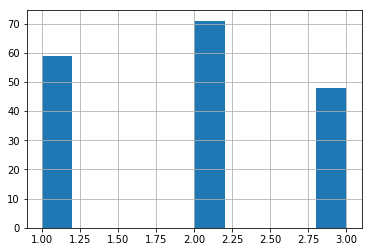

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [16]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
'''
Информация, нужная нам, про датасет 

Number of Attributes 13:
    1) Alcohol
    2) Malic acid
    3) Ash
    4) Alcalinity of ash  
    5) Magnesium
    6) Total phenols
    7) Flavanoids
    8) Nonflavanoid phenols
    9) Proanthocyanins
    10)Color intensity
    11)Hue
    12)OD280/OD315 of diluted wines
    13)Proline  

Number of classes 3:
    class 1 59
    class 2 71
    class 3 48
    
Missing Attribute Values:
    None
    
ВЫВОД: Целевая переменная лежит в 0
1-13 -- фичи
'''
data = pd.read_csv(
    io.StringIO(requests.get(URL).content.decode('utf-8')), 
    header=None)
print('data rows: {} \ndata columns: {}'.format(*data.shape))

data[0].hist()
plt.show()
data.head()

Наша итоговая цель в этом задании — нарисовать объекты датасета на плоскости и посмотреть, как алгоритм делит плоскость на классы и как это влияет на результаты на тестовой выборке. Кроме этого мы рассмотрим разные параметры алгоритма. Первая проблема состоит в том, что в датасете больше двух признаков — непонятно, как объекты изображать на плоскости. Обычно в такой ситуации используются методы снижения размерности (например, PCA), но мы про них ещё не говорили, поэтому воспользуемся другим подходом: попробуем выделить среди признаков те, которые (по одиночке) дают максимум информации о значении целевой переменной (это называется univariate feature selection).

**2. (0.5 балла)**  Функция `sklearn.feature_selection.mutual_info_classif` находит *взаимную информацию* между целевой переменной и каждым из признаков. Чем больше взаимная информация, тем больше знание одной переменной сообщает нам о возможных значениях другой переменной. С помощью этой функции выберите два признака, которые имеют максимальную взаимную информацию с целевой переменной. Создайте из них numpy-массив $X$ и создайте массив $y$ со значениями целевой переменной. После чего разделите данные на обучающую и тестовую выборки в соотношении 2:1, воспользовавшись вашей функцией `strat_kfold_gen` и взяв только один элемент из возвращённого списка (или генератора).

In [25]:
from sklearn.feature_selection import mutual_info_classif

x = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
feature_info = mutual_info_classif(x, y)
print(feature_info) # => best 6 and 12!!!
inds = np.argsort(mutual_info_classif(x, y))[-2:] 
print(inds)
x_train, y_train, x_test, y_test = strat_kfold_gen(scale(x[:, inds]), 
                                                   y, k=3)[0]

[0.47138339 0.27673113 0.0538021  0.20999124 0.20361188 0.41175088
 0.66227591 0.12451914 0.27831685 0.55173763 0.4473559  0.49824942
 0.55586755]
[12  6]


В следующем задании вопользуйтесь примерами из интернета ([[1]](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html), [[2]](https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib), [[3]](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/tutorial/plot_knn_iris.html) и т.д. на ваш выбор), чтобы построить график следующего типа. Каждая точка плоскости (decision boundaries) покрашена в свой цвет в зависимости от того, какое предсказание сделает алгоритм для этой точки, а объекты раскрашены в тот цвет, какой у них истинный $y$.

![data/example.png](data/example.png)

**3. (2 балла)** Переберите $M$ значений параметра $k$ (можете добавить значение 0 как индикатор использования взвешенного kNN), $L$ значений параметра $p$ (порядок расстояния Минковского) и постройте сетку $L \times M$  графиков типа выше. ($M$ и $L$ — небольшие целые числа, больше 3.)

На графиках должны быть:

- подпись: набор параметров и качество (accuracy) до третьего знака после запятой;
- окрашенные в цвет истинного класса точки обучающей и тестовой выборки
    - сделайте маркеры обучающей и тестовой выборок различными (например, треугольники и кружочки/черная и белая обводка/маленький и большой размер);
- границы принятия решений (decision boundaries) на основе обученного (на обучающей выборке) алгоритма kNN;
- общее название сетки графиков, где в том числе указаны номера признаков, выбранные в предыдущем пункте.

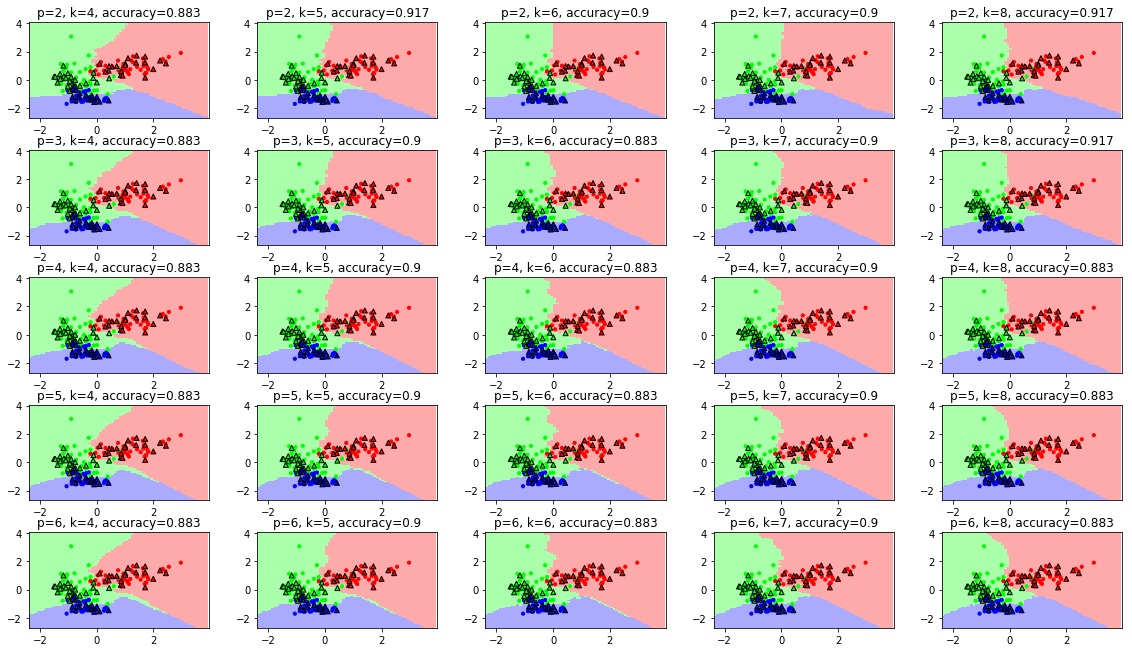

best p=2, best k=5, accuracy=0.9166666666666666


In [26]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

minK = 4 
minP = 2
M, L = 5, 5

rangeK = range(0, M)
rangeP = range(0, L)

fig, axs = plt.subplots(L, M, figsize=(16, 9))
fig.tight_layout()


X = x_train # 2d massive
Y = y_train

step = 0.1

# https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
max_accuracy = 0
best_p = 0
best_k = 0

x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

x1grid, x2grid = np.meshgrid(np.arange(x1_min, x1_max, step),
                     np.arange(x2_min, x2_max, step))

for p in rangeP:
    for k in rangeK:
        Z = knn_classifier(X, Y, np.c_[x1grid.ravel(), x2grid.ravel()], k=k+minK, distance=p+minP)
        Z = Z.reshape(x1grid.shape)
        
        axs[p, k].pcolormesh(x1grid, x2grid, Z, cmap=cmap_light)
        
        # train data plot        
        axs[p, k].scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold, marker='o', s=10)
        
        # test data plot
        axs[p, k].scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cmap_bold,
            edgecolor='k',marker='^', s=25)
        
        axs[p, k].set_xlim(x1_min, x1_max)
        axs[p, k].set_ylim(x2_min, x2_max)
        
        accuracy = metrics.accuracy_score(knn_classifier(X, Y, x_test, k=k + minK, distance=p + minP), y_test)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_p = p + minP
            best_k = k + minK
        axs[p, k].set_title(f"p={p + minP}, k={k + minK}, accuracy={round(accuracy, 3)}")

plt.show()
print(f"best p={best_p}, best k={best_k}, accuracy={max_accuracy}")

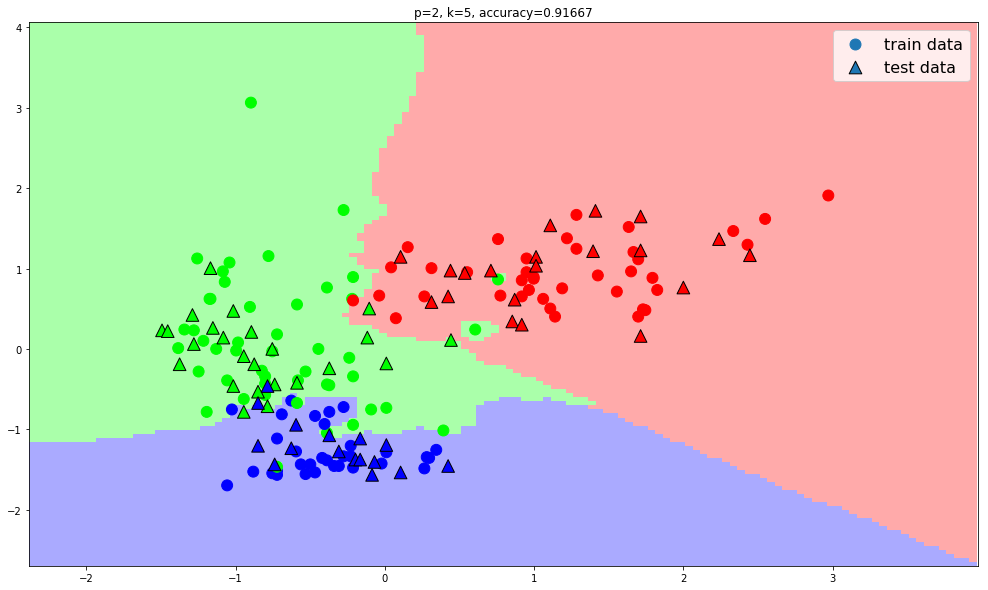

best p=2, best k=5, accuracy=0.9166666666666666


In [27]:
step = 0.05

x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

x1grid, x2grid = np.meshgrid(np.arange(x1_min, x1_max, step),
                     np.arange(x2_min, x2_max, step))

Z = knn_classifier(X, Y, np.c_[x1grid.ravel(), x2grid.ravel()], k=best_k, distance=best_p)
Z = Z.reshape(x1grid.shape)

plt.figure(figsize=(17,10))
plt.pcolormesh(x1grid, x2grid, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold, marker='o', s=120, label='train data')

# test data plot
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cmap_bold,
            edgecolor='k',marker='^', s=160, label='test data')

plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.title(f"p={best_p}, k={best_k}, accuracy={round(max_accuracy,5)}", fontsize=12)
plt.legend(loc='best', fontsize=16)
plt.show()


print(f"best p={best_p}, best k={best_k}, accuracy={max_accuracy}")

У какого набора параметров получилось лучшее качество?

Объясните как параметры влияют на decision boundaries.

**Ваш ответ:**

Наилучшая точность получилась при $p, k$ (и точность) такие, как указаны выше.

Изменение $p$ влияет на то, как сильно будет изгибаться линия границы (как сильно она будет "острой", менее гладкой)

Изменение $k$ -- на то где эти границы будут находиться.